In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import tensorflow as tf
import coco
import utils
import model as modellib
from visualize import display_images
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_humanpose.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
COCO_DIR = "images"  # TODO: enter value here
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# configurations

In [2]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [3]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
if config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


Configurations Superlee:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
KEYPOINT_MASK_POOL_SIZE        7
KEYPOINT_MASK_SHAPE            [56, 56]
KEYPOINT_THRESHOLD             0.005
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
LIMBS                          [0, -1, -1, 5, -1, 6, 5, 7, 6, 8, 7, 9, 8, 10, 11, 13, 12, 14, 13, 15, 14, 16]
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               128
MEAN_PIXEL                  

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# load dataset

In [5]:
# Load dataset
assert config.NAME == "coco"
# Training dataset
#load person keypoints dataset
train_dataset_keypoints = coco.CocoDataset(task_type="person_keypoints")
train_dataset_keypoints.load_coco(COCO_DIR, "train")
train_dataset_keypoints.prepare() 
print("Train Keypoints Image Count: {}".format(len(train_dataset_keypoints.image_ids)))
print("Train Keypoints Class Count: {}".format(train_dataset_keypoints.num_classes))
for i, info in enumerate(train_dataset_keypoints.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=10.29s)
creating index...
index created!
Skeleton: (19, 2)
Keypoint names: (17,)
Train Keypoints Image Count: 64115
Train Keypoints Class Count: 2
  0. BG                                                
  1. person                                            


# Run detection

image ID: coco.513729 (59498) http://cocodataset.org/#explore?id=513729
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
windows                  shape: (1, 4)                min:    0.00000  max: 1024.00000
rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000
rpn_bbox                 shape: (1, 261888, 4)        min:   -8.78155  max:  144.05975
rois                     shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
mrcnn_class              shape: (1, 1000, 2)          min:    0.00015  max:    0.99985
mrcnn_bbox               shape: (1, 1000, 2, 4)       min:   -2.99800  max:    4.13096
detections               shape: (1, 100, 6)           min:    0.00000  max:  823.00000
mrcnn_mask               shape: (1, 10

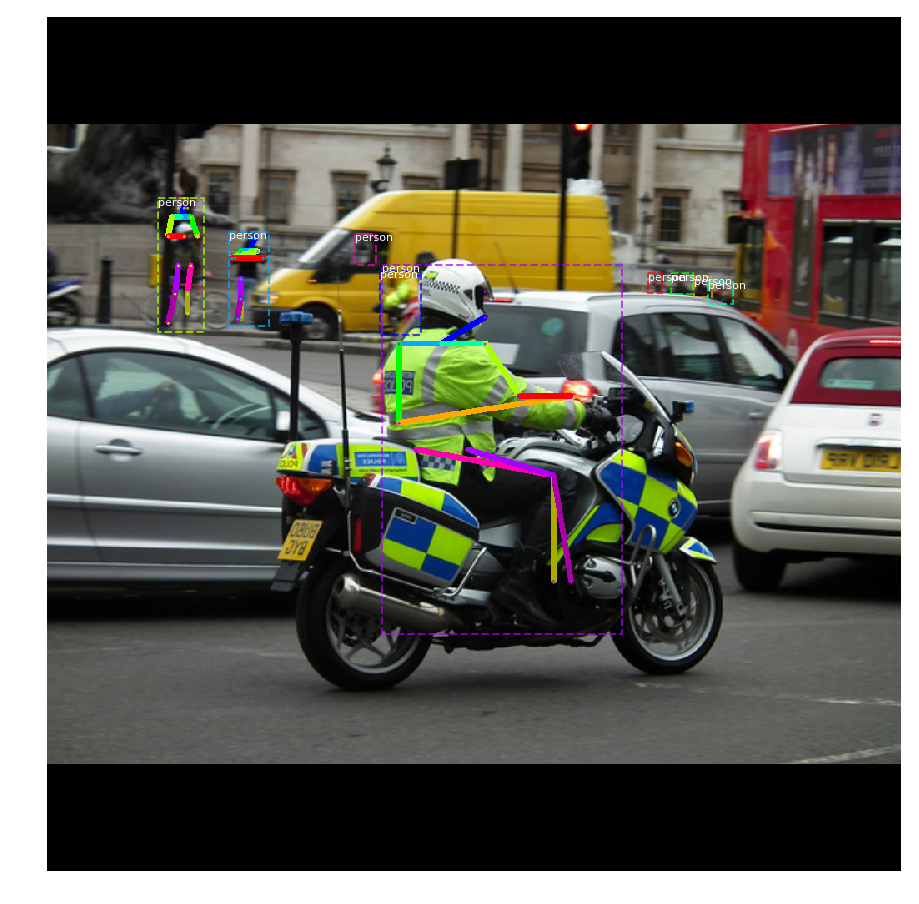

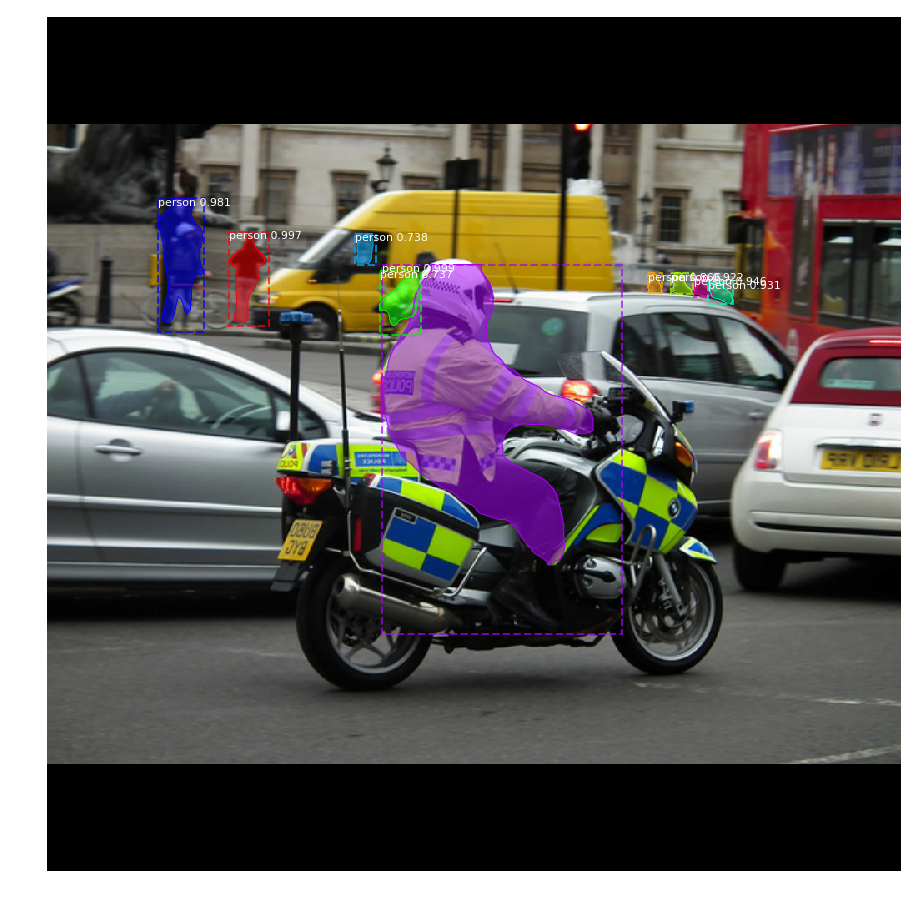

In [6]:
import cv2
image_id = random.choice(train_dataset_keypoints.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask, gt_keypoint =\
    modellib.load_image_gt_keypoints(train_dataset_keypoints, config, 
                           image_id, use_mini_mask=config.USE_MINI_MASK)
info = train_dataset_keypoints.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       train_dataset_keypoints.image_reference(image_id)))


results = model.detect_keypoint([image], verbose=1)
r = results[0] # for one image

visualize.display_keypoints(image,r['rois'],r['keypoints'],r['class_ids'], train_dataset_keypoints.class_names,skeleton = config.LIMBS)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                             train_dataset_keypoints.class_names, r['scores'])


In [16]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'],r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

ValueError: shapes (5,1048576) and (3136,3) not aligned: 1048576 (dim 1) != 3136 (dim 0)

In [7]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (150, 4)              min:   -3.17128  max:    2.32019
positive_anchors         shape: (21, 4)               min:  -26.50967  max:  824.00000
negative_anchors         shape: (129, 4)              min:  -85.01934  max: 1042.62742
neutral anchors          shape: (261738, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (21, 4)               min:    0.00000  max:  823.00000


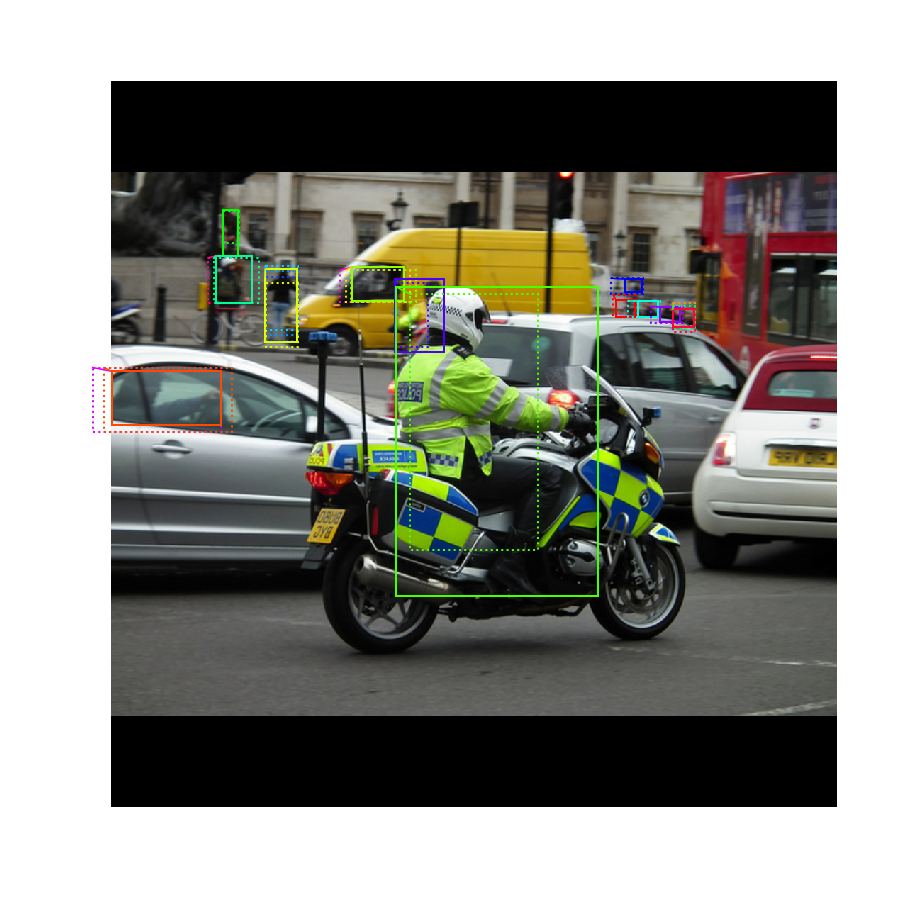

In [8]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [1]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

NameError: name 'model' is not defined

In [12]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

NameError: name 'rpn' is not defined

In [14]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

ValueError: Cannot feed value of shape (1024, 1024, 3) for Tensor 'input_image:0', which has shape '(?, 1024, 1024, 3)'

In [15]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

NameError: name 'mrcnn' is not defined

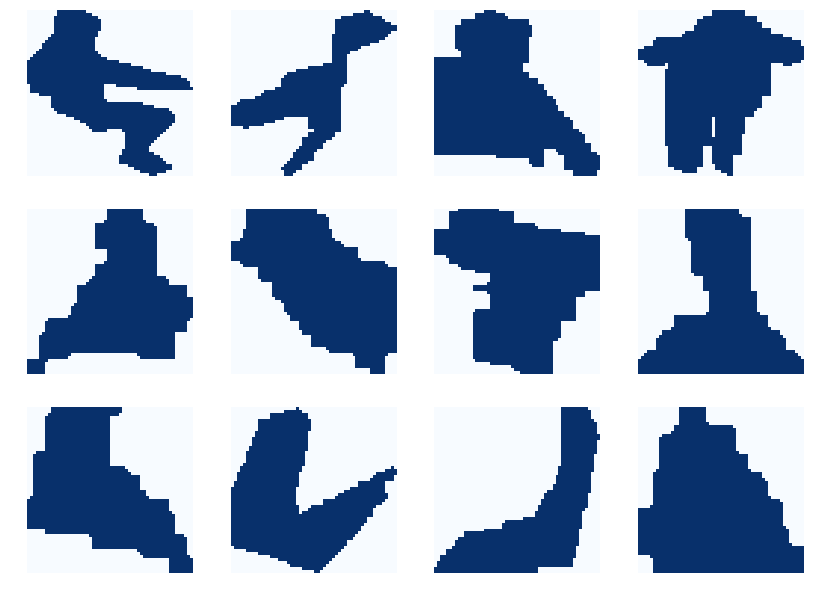

In [16]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [17]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))


ValueError: Cannot feed value of shape (1024, 1024, 3) for Tensor 'input_image:0', which has shape '(?, 1024, 1024, 3)'

In [18]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

NameError: name 'det_masks' is not defined

In [19]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

ValueError: Cannot feed value of shape (1024, 1024, 3) for Tensor 'input_image:0', which has shape '(?, 1024, 1024, 3)'

In [20]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

NameError: name 'activations' is not defined